# Correlation between single trials and prediction error (3 tasks)
* Using single trial beta maps, I correlate the PE values from model 2 (Jepma)
* The correlation coefficients are converted to fisher z scores and saved as subject-wise correlation maps
* In this notebook, I concatenate the subject-wise correlation maps and conduct a t-test
* Afterwards, I convert back the fisher-z to correlation values and plot the thresholded maps

In [45]:
import numpy as np
import glob
import os
import pathlib
import re
import statsmodels 
from statsmodels.stats import multitest
import scipy
import nilearn
from scipy import stats
from nilearn.image import resample_to_img, math_img
from nilearn import image
from nilearn import plotting
import argparse
from nilearn.image import new_img_like
import matplotlib.pyplot as plt
from os.path import join


# pain

### 1) load and stack images
conduct t-test
convert values back to corr values



In [46]:
main_dir = '/Volumes/spacetop_projects_cue/'
task = 'pain'
fmri_event = 'stimulus'
beh_regressor = 'PE'
nii_flist = glob.glob(join(main_dir, 'analysis', 'fmri', 'nilearn', 'covariate', beh_regressor, task,  f"sub-*_task-{task}_corr_x-{fmri_event}_y-{beh_regressor}.nii.gz" ))

remove_sub = [1]
filtered_file_list = [file_path for file_path in nii_flist if not any(str(num) in file_path for num in remove_sub)]

# stack all files into a 4d nifti
concatenated_image = image.concat_imgs(sorted(filtered_file_list))


In [47]:
print(f"* number of nifti files: {len(filtered_file_list)}")
print(f"* example list of files: \n{filtered_file_list[0:5]}")
print(f"* check shape of concatenated images: {concatenated_image.get_fdata().shape}")

* number of nifti files: 34
* example list of files: 
['/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/covariate/PE/pain/sub-0060_task-pain_corr_x-stimulus_y-PE.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/covariate/PE/pain/sub-0039_task-pain_corr_x-stimulus_y-PE.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/covariate/PE/pain/sub-0089_task-pain_corr_x-stimulus_y-PE.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/covariate/PE/pain/sub-0050_task-pain_corr_x-stimulus_y-PE.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/covariate/PE/pain/sub-0092_task-pain_corr_x-stimulus_y-PE.nii.gz']
* check shape of concatenated images: (73, 86, 73, 34)


### 2) mask images

In [48]:
mask = image.load_img('/Users/h/Documents/MATLAB/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii')
first_image = image.index_img(concatenated_image, 0)
mask_img = nilearn.masking.compute_epi_mask(mask, target_affine = first_image.affine, target_shape = first_image.shape)

nifti_masker = nilearn.maskers.NiftiMasker(mask_img= mask_img,
                                           smoothing_fwhm=6,
                            target_affine = first_image.affine, target_shape = first_image.shape, 
                    memory="nilearn_cache", memory_level=1)

fmri_masked_pain = nifti_masker.fit_transform(concatenated_image)

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:542: UserWarning: Persisting input arguments took 0.62s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(


/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/_utils/niimg.py:62: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


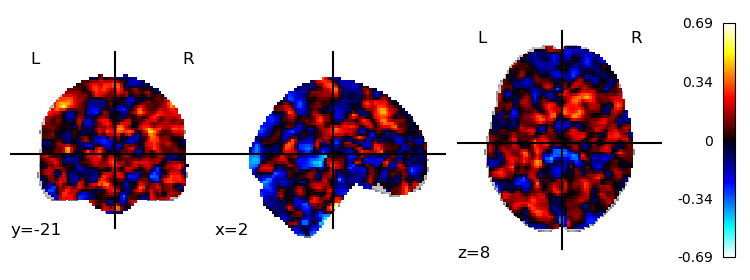

In [49]:
plotting.plot_stat_map(first_image)


In [50]:
print(f"* mask applied array shape: {fmri_masked_pain.shape}")

* mask applied array shape: (34, 98053)


### 3) ttest

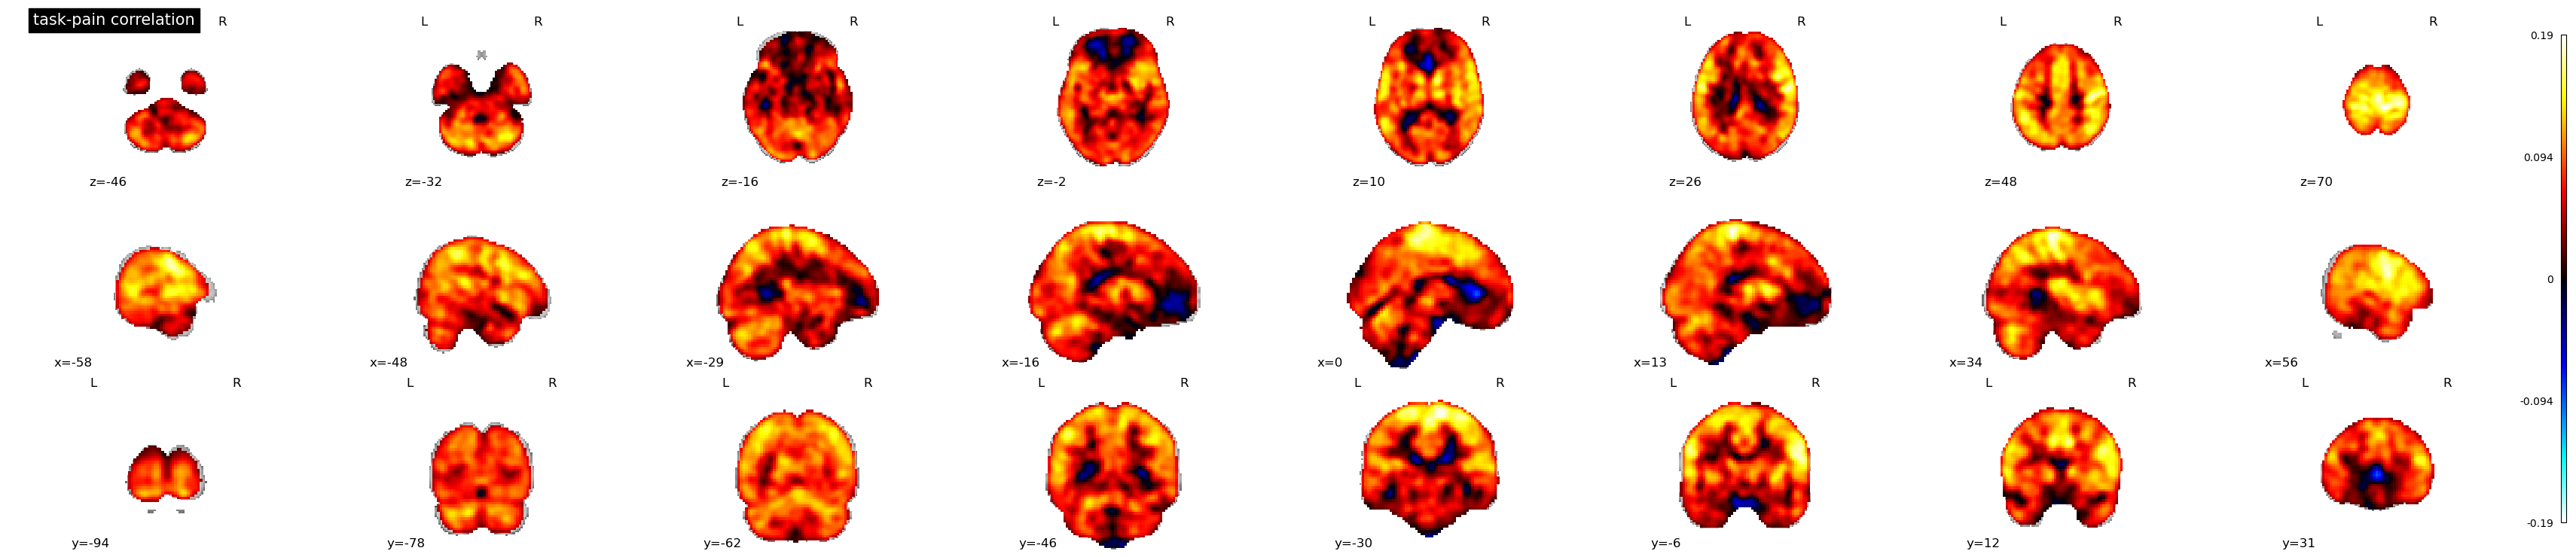

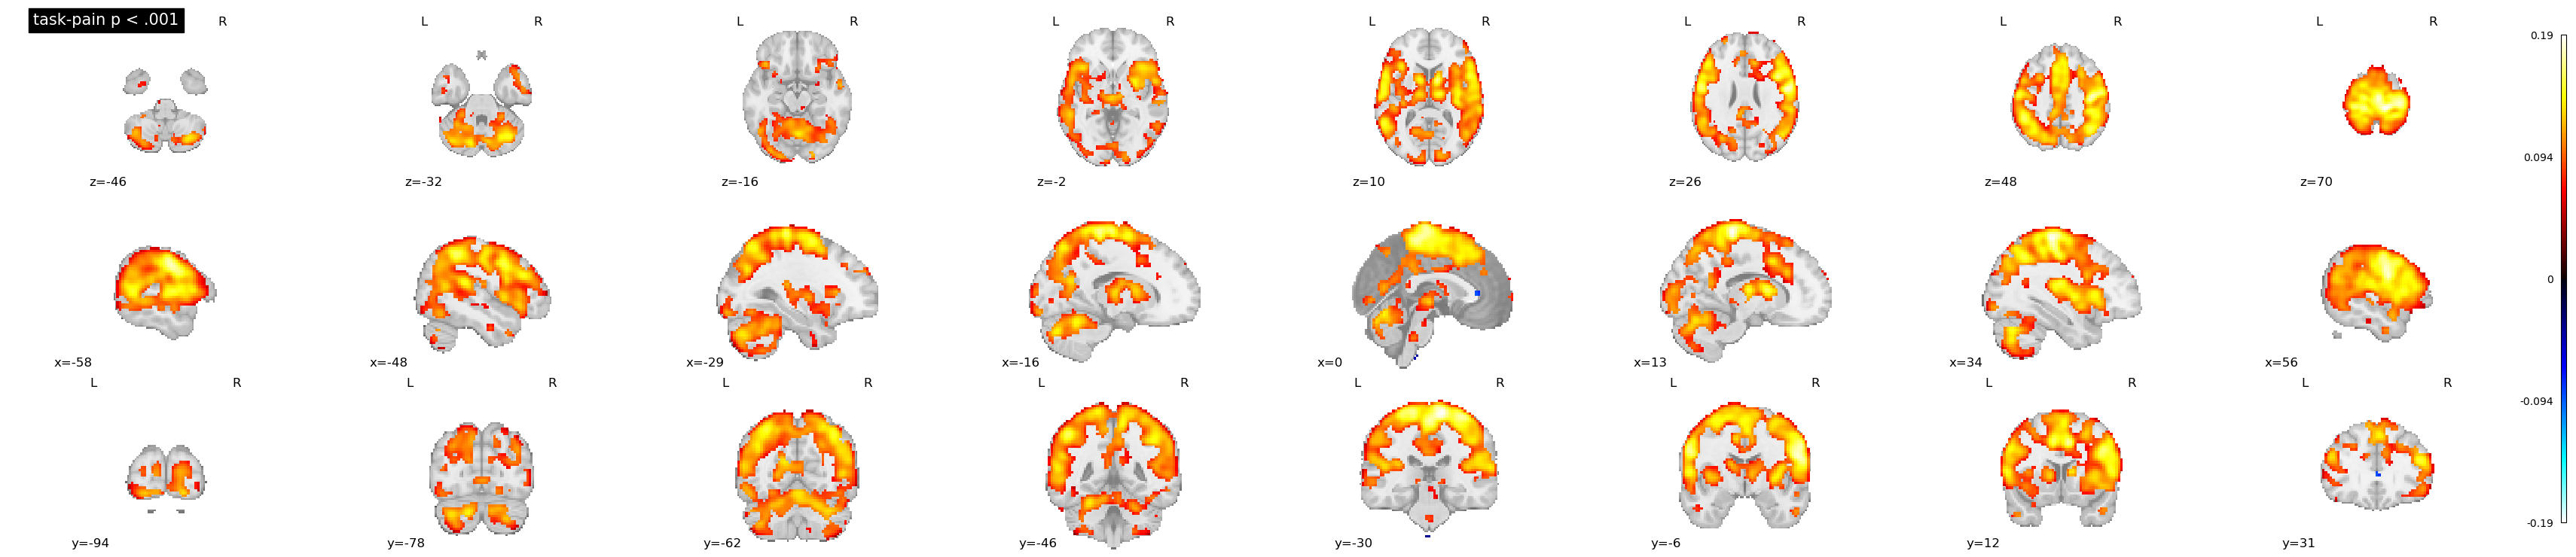

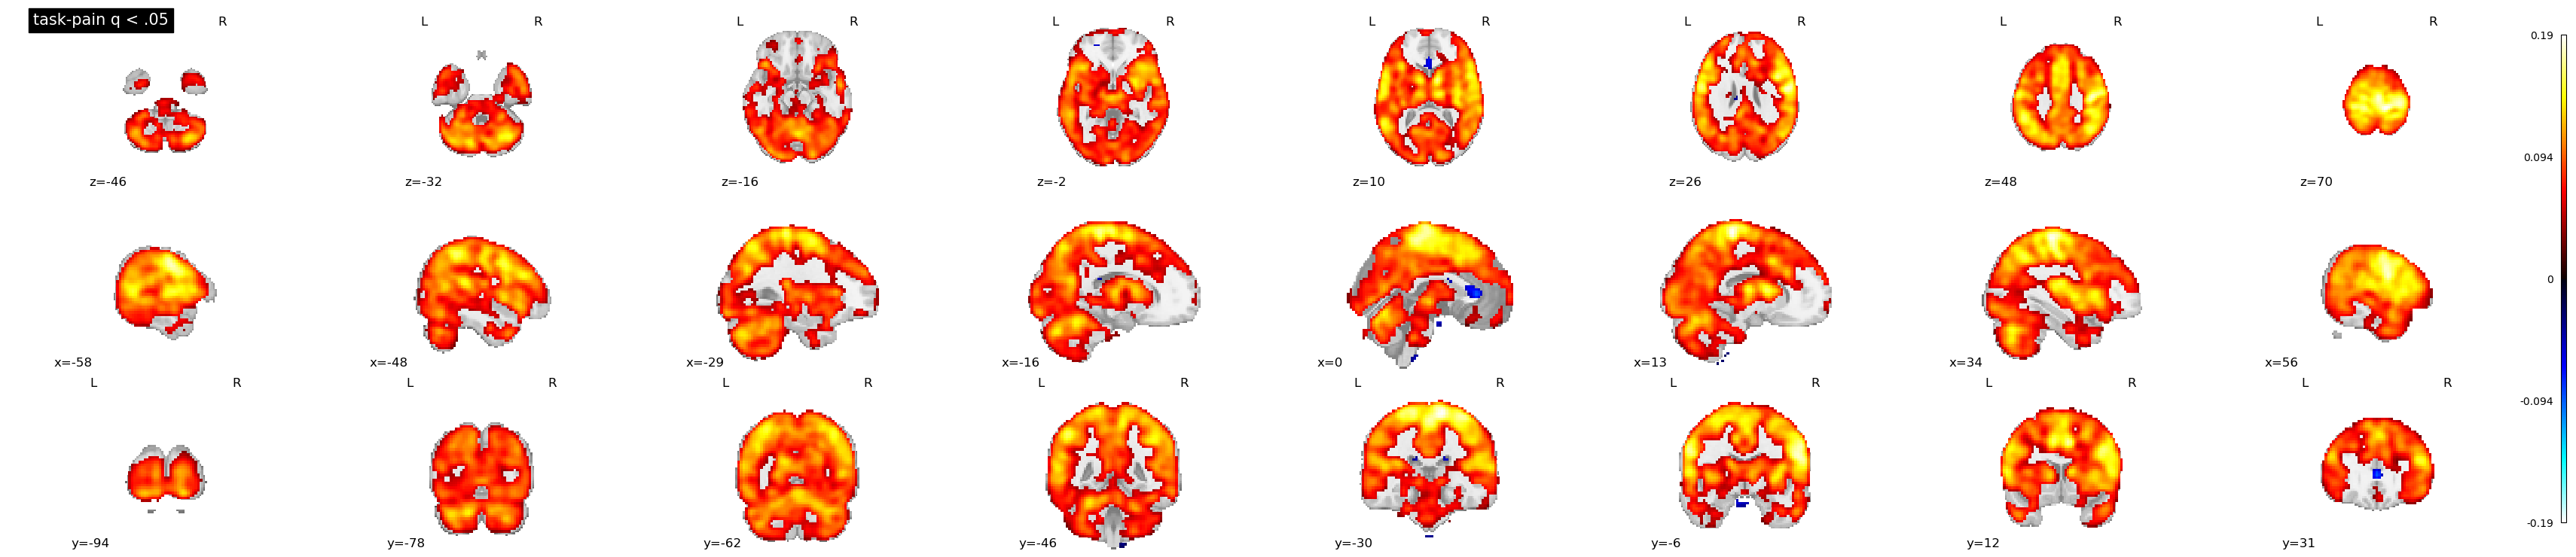

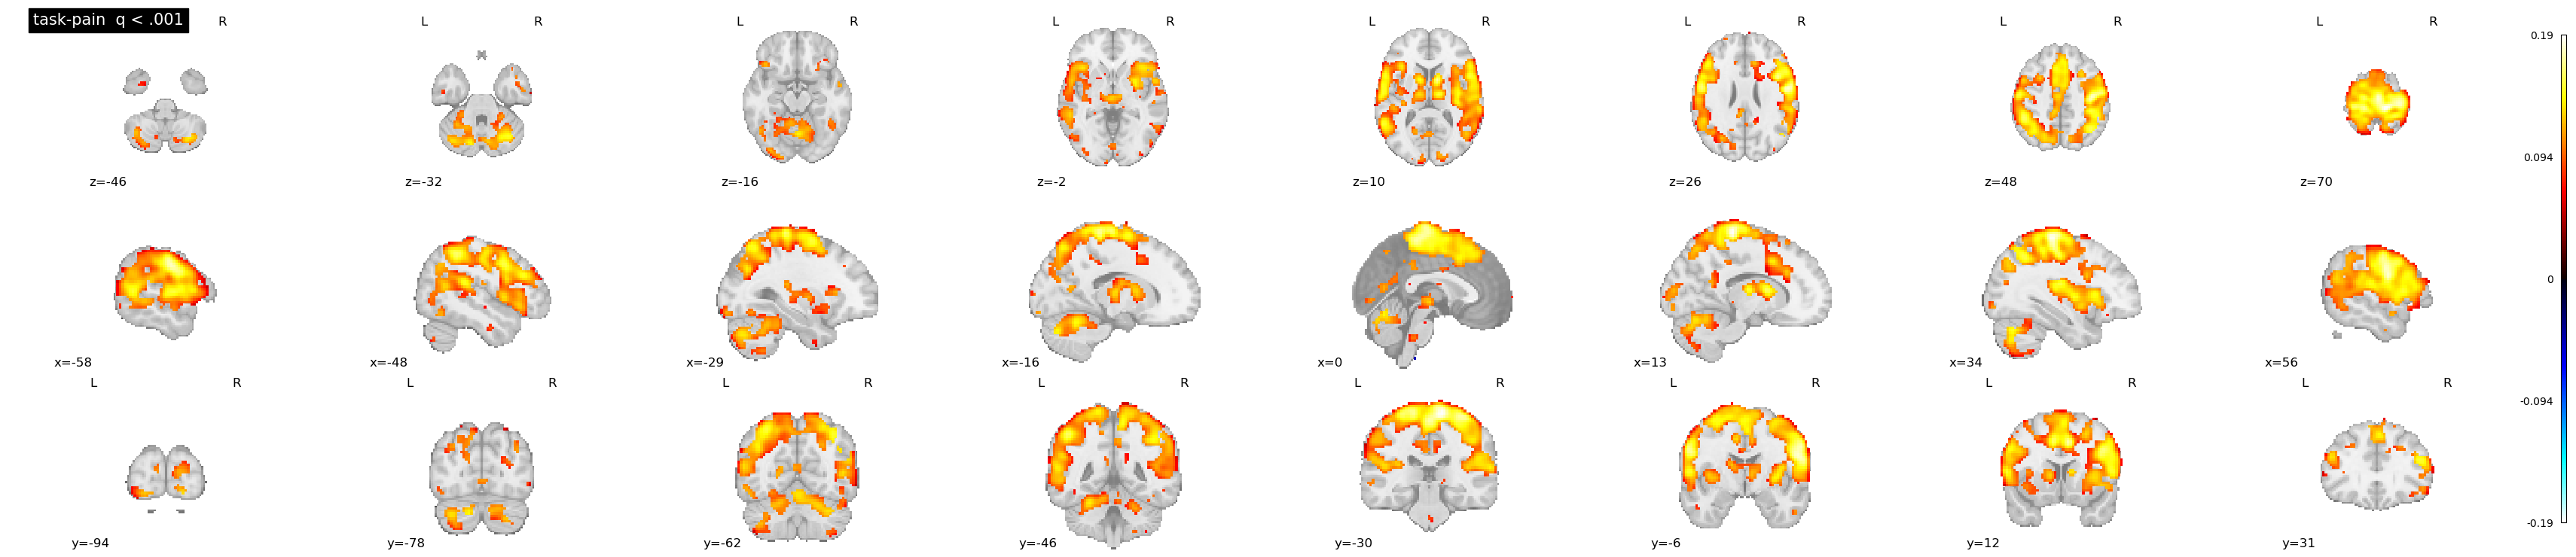

In [51]:
tvalues, pvalues = scipy.stats.ttest_1samp(fmri_masked_pain, popmean=0,axis=0, alternative='two-sided', nan_policy = 'propagate')
reject, qvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')
tanhcorr_t = np.tanh(np.nanmean(fmri_masked_pain, axis = 0))
                     
# map 1
pain_con_t = nifti_masker.inverse_transform(tanhcorr_t)

# map 1-1
result_unc001 = np.zeros(fmri_masked_pain.shape[1])
result_unc001[pvalues < .001] = tanhcorr_t[pvalues < .001] #tvalues[qvalues < .05]
pain_corr_unc001 = nifti_masker.inverse_transform(result_unc001)

# map 2
result_mapp = np.zeros(fmri_masked_pain.shape[1])
result_mapp[qvalues < .05] = tanhcorr_t[qvalues < .05] #tvalues[qvalues < .05]
pain_corr_q05 = nifti_masker.inverse_transform(result_mapp)

# map 3
result_map_001p = np.zeros(fmri_masked_pain.shape[1])
result_map_001p[qvalues < .001] = tanhcorr_t[qvalues < .001] #tvalues[qvalues < .001]
pain_corr_q001 = nifti_masker.inverse_transform(result_map_001p)

plotting.plot_stat_map(pain_con_t,  display_mode = 'mosaic', title = f'task-{task} correlation', cut_coords = 8)
plotting.plot_stat_map(pain_corr_unc001,  display_mode = 'mosaic', title = f'task-{task} p < .001', cut_coords = 8)
plotting.plot_stat_map(pain_corr_q05,  display_mode = 'mosaic', title = f'task-{task} q < .05', cut_coords = 8)
plotting.plot_stat_map(pain_corr_q001,  display_mode = 'mosaic', title = f'task-{task}  q < .001', cut_coords = 8)

# vicarious

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


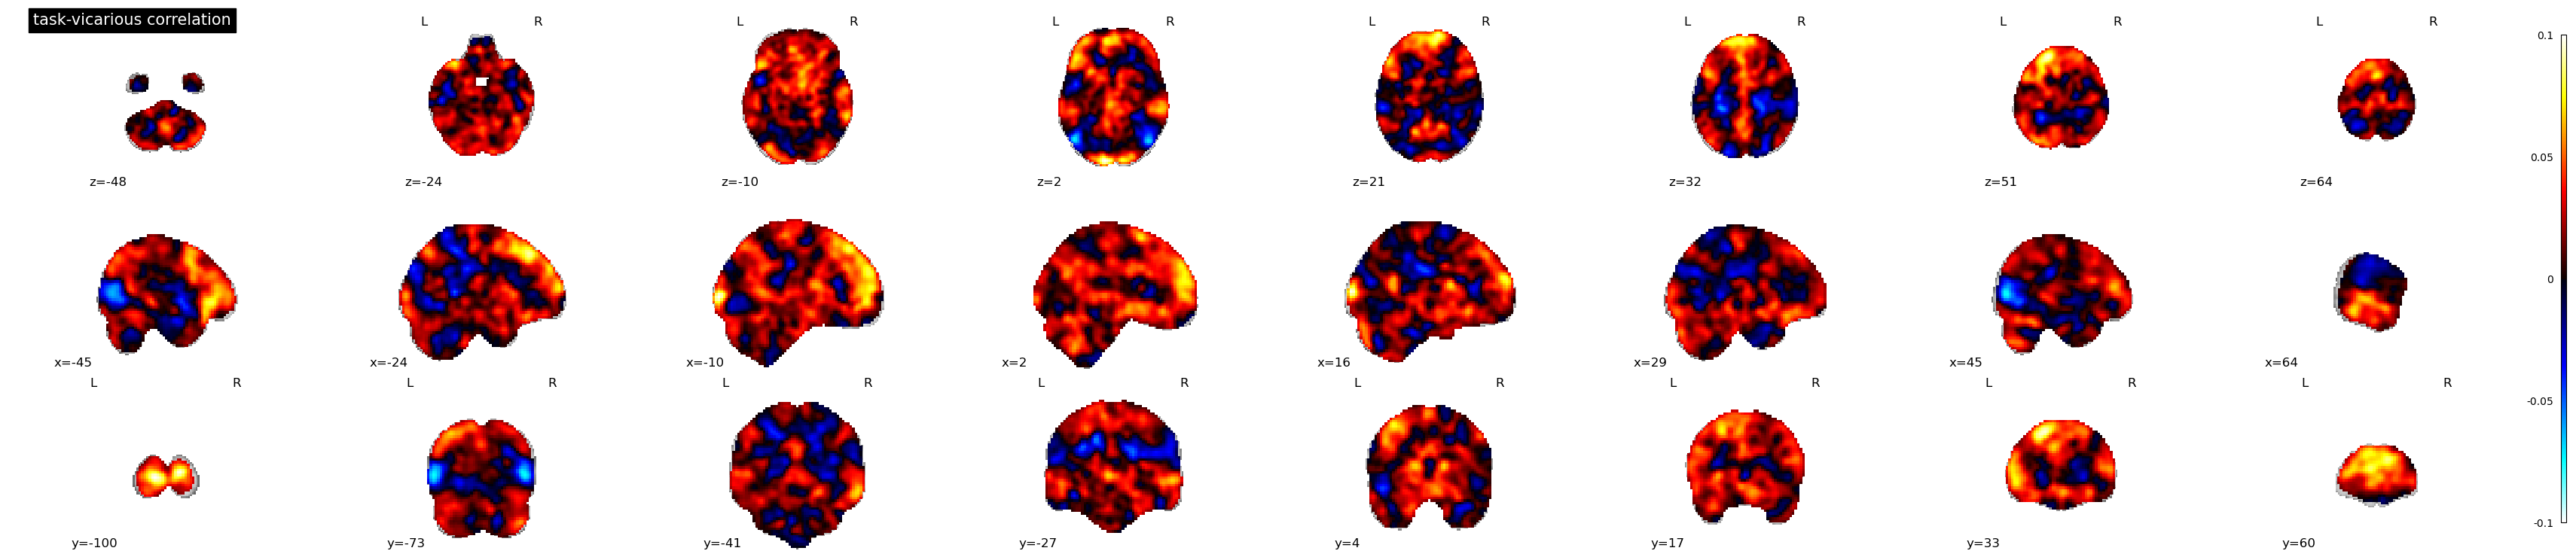

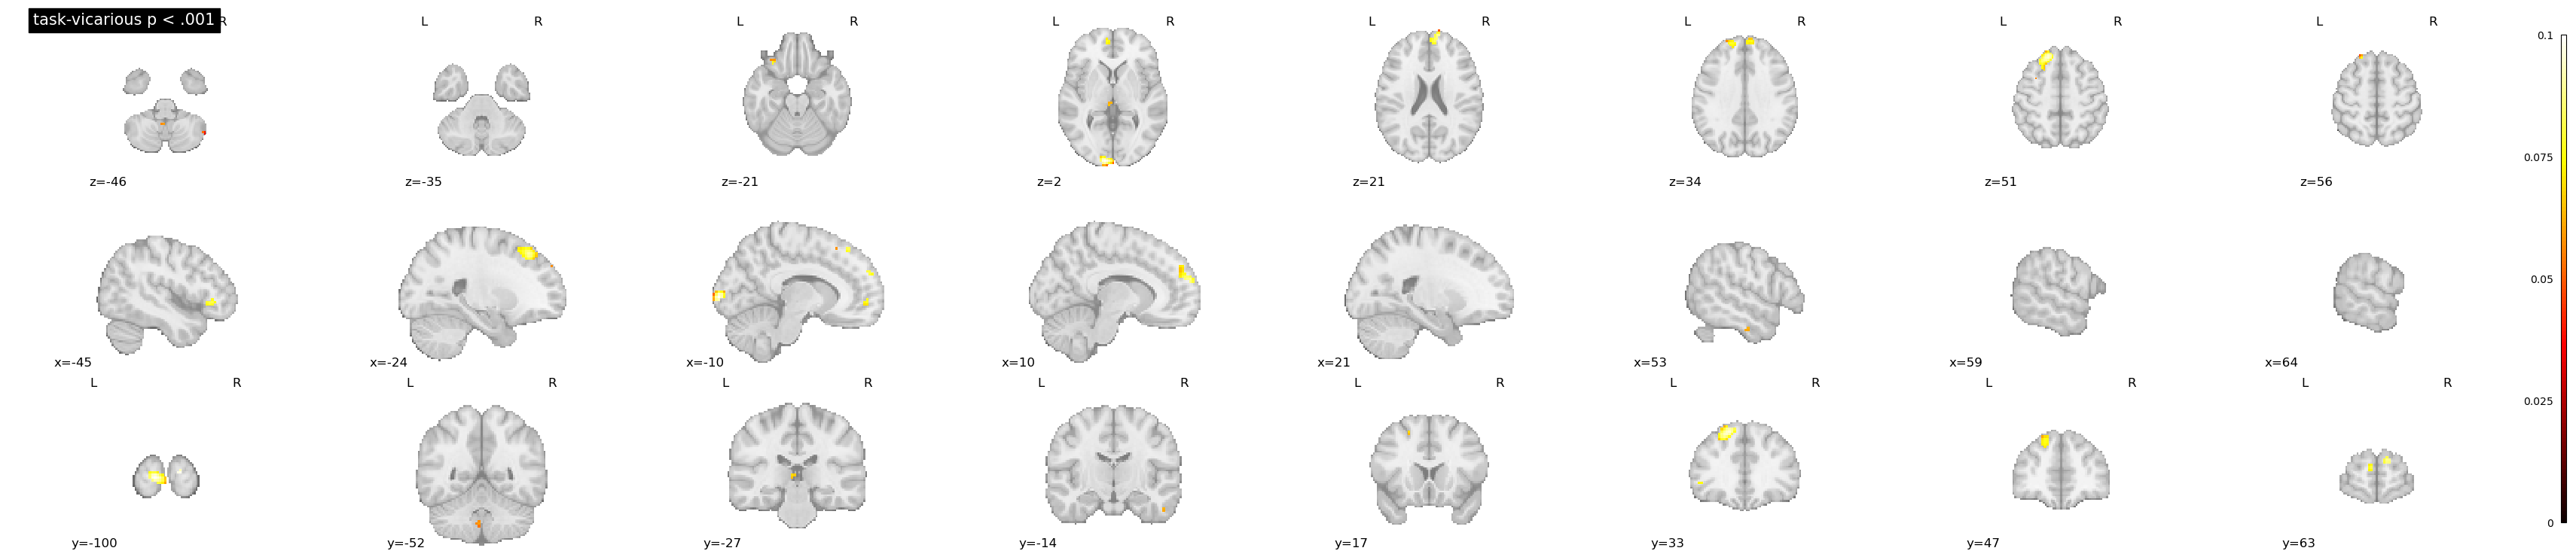

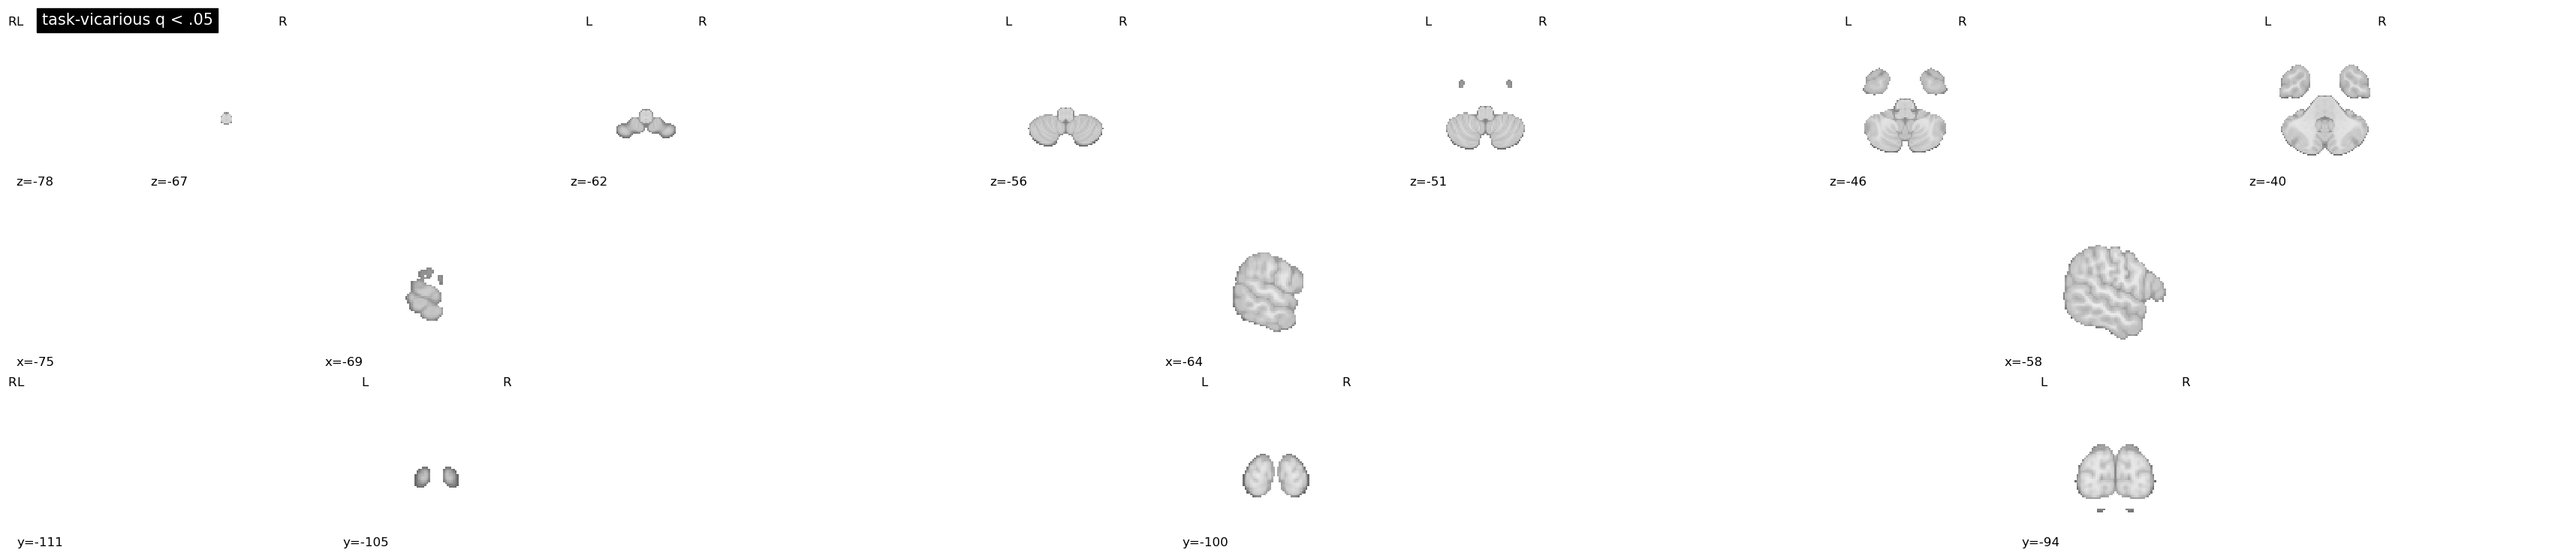

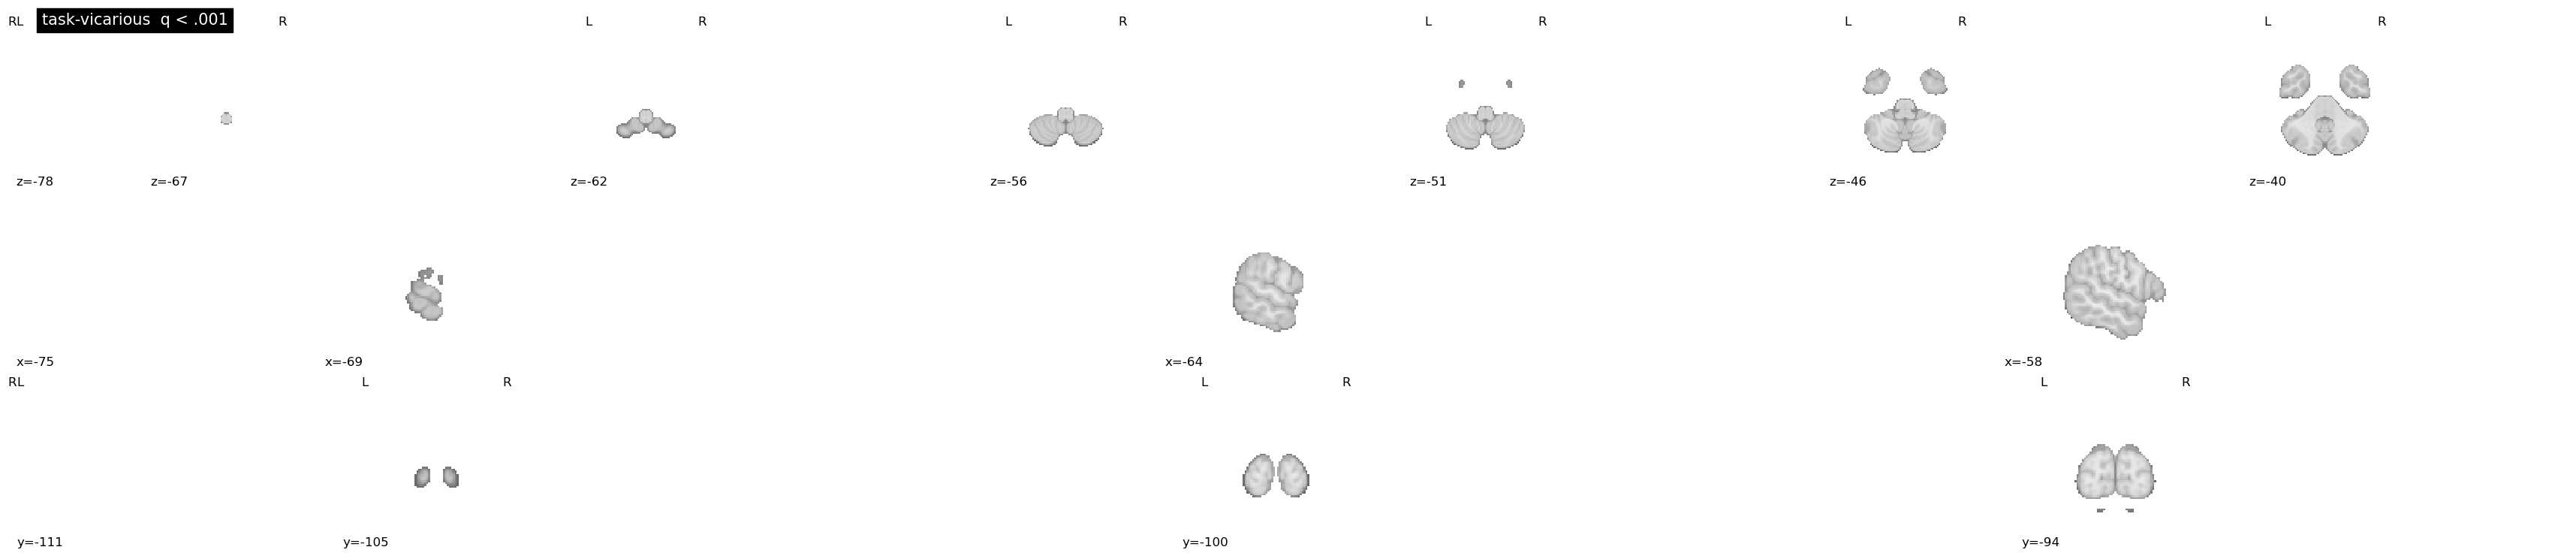

In [52]:
main_dir = '/Volumes/spacetop_projects_cue/'
task = 'vicarious'
fmri_event = 'stimulus'
beh_regressor = 'PE'
nii_vic_flist = glob.glob(join(main_dir, 'analysis', 'fmri', 'nilearn', 'covariate', beh_regressor, task, f"sub-*_task-{task}_corr_x-{fmri_event}_y-{beh_regressor}.nii.gz" ))

remove_sub = [1]
filtered_file_list = [file_path for file_path in nii_vic_flist if not any(str(num) in file_path for num in remove_sub)]

# stack all files into a 4d nifti
concat_vic_nii = image.concat_imgs(sorted(filtered_file_list))
fmri_masked_vic = nifti_masker.fit_transform(concat_vic_nii)
tvalues = []; pvalues = []
tvalues, pvalues = scipy.stats.ttest_1samp(fmri_masked_vic, popmean=0,axis=0, alternative='two-sided', nan_policy = 'propagate')
reject, qvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')
tanhcorr_t = np.tanh(np.nanmean(fmri_masked_vic, axis = 0))
                     
# map 1
vic_corr = nifti_masker.inverse_transform(tanhcorr_t)

# map 1-1
result_unc001 = np.zeros(fmri_masked_vic.shape[1])
result_unc001[pvalues < .001] = tanhcorr_t[pvalues < .001] #tvalues[qvalues < .05]
vic_corr_unc001 = nifti_masker.inverse_transform(result_unc001)

# map 2
result_mapp = np.zeros(fmri_masked_vic.shape[1])
result_mapp[qvalues < .05] = tanhcorr_t[qvalues < .05] #tvalues[qvalues < .05]
vic_corr_q05 = nifti_masker.inverse_transform(result_mapp)

# map 3
result_map_001p = np.zeros(fmri_masked_vic.shape[1])
result_map_001p[qvalues < .001] = tanhcorr_t[qvalues < .001] #tvalues[qvalues < .001]
vic_corr_q001 = nifti_masker.inverse_transform(result_map_001p)

plotting.plot_stat_map(vic_corr,  display_mode = 'mosaic', title = f'task-{task} correlation', cut_coords = 8)
plotting.plot_stat_map(vic_corr_unc001,  display_mode = 'mosaic', title = f'task-{task} p < .001', cut_coords = 8)
plotting.plot_stat_map(vic_corr_q05,  display_mode = 'mosaic', title = f'task-{task} q < .05', cut_coords = 8)
plotting.plot_stat_map(vic_corr_q001,  display_mode = 'mosaic', title = f'task-{task}  q < .001', cut_coords = 8)

# cognitive

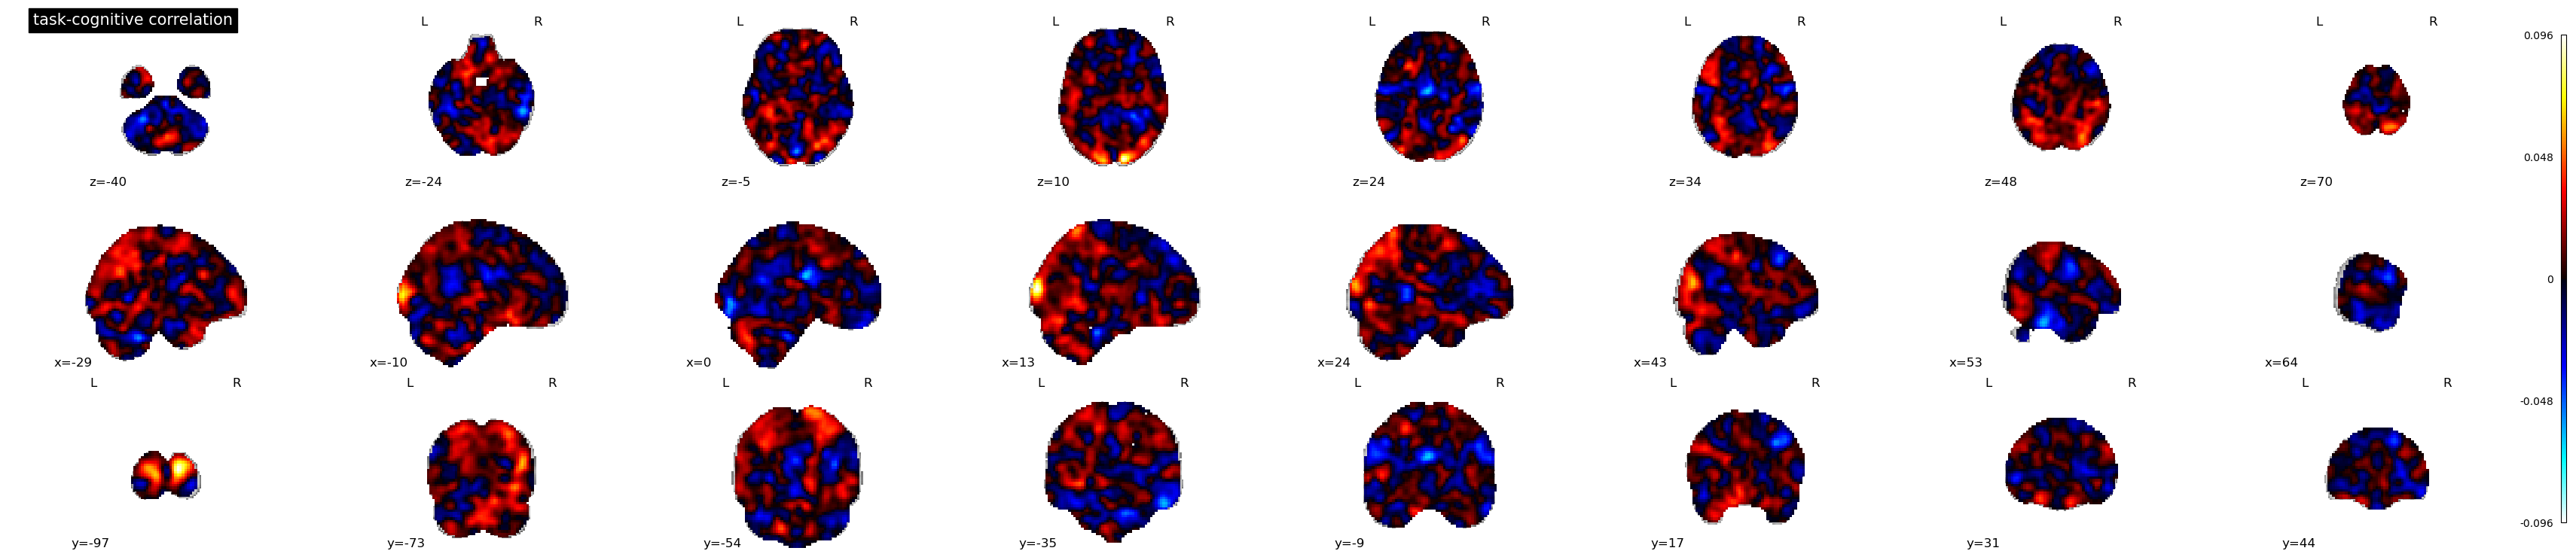

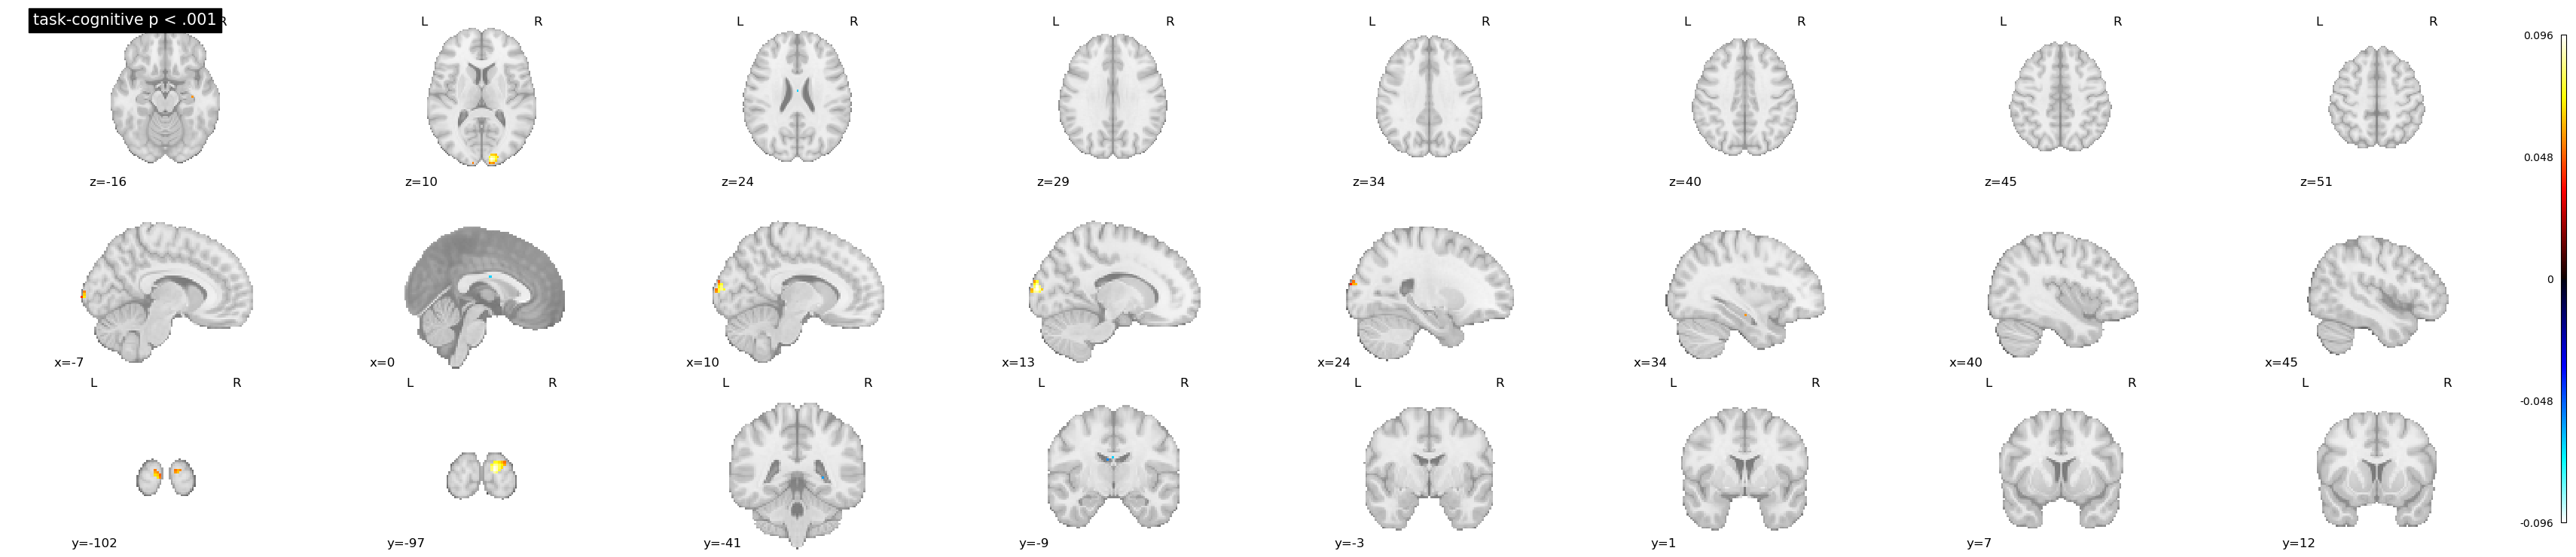

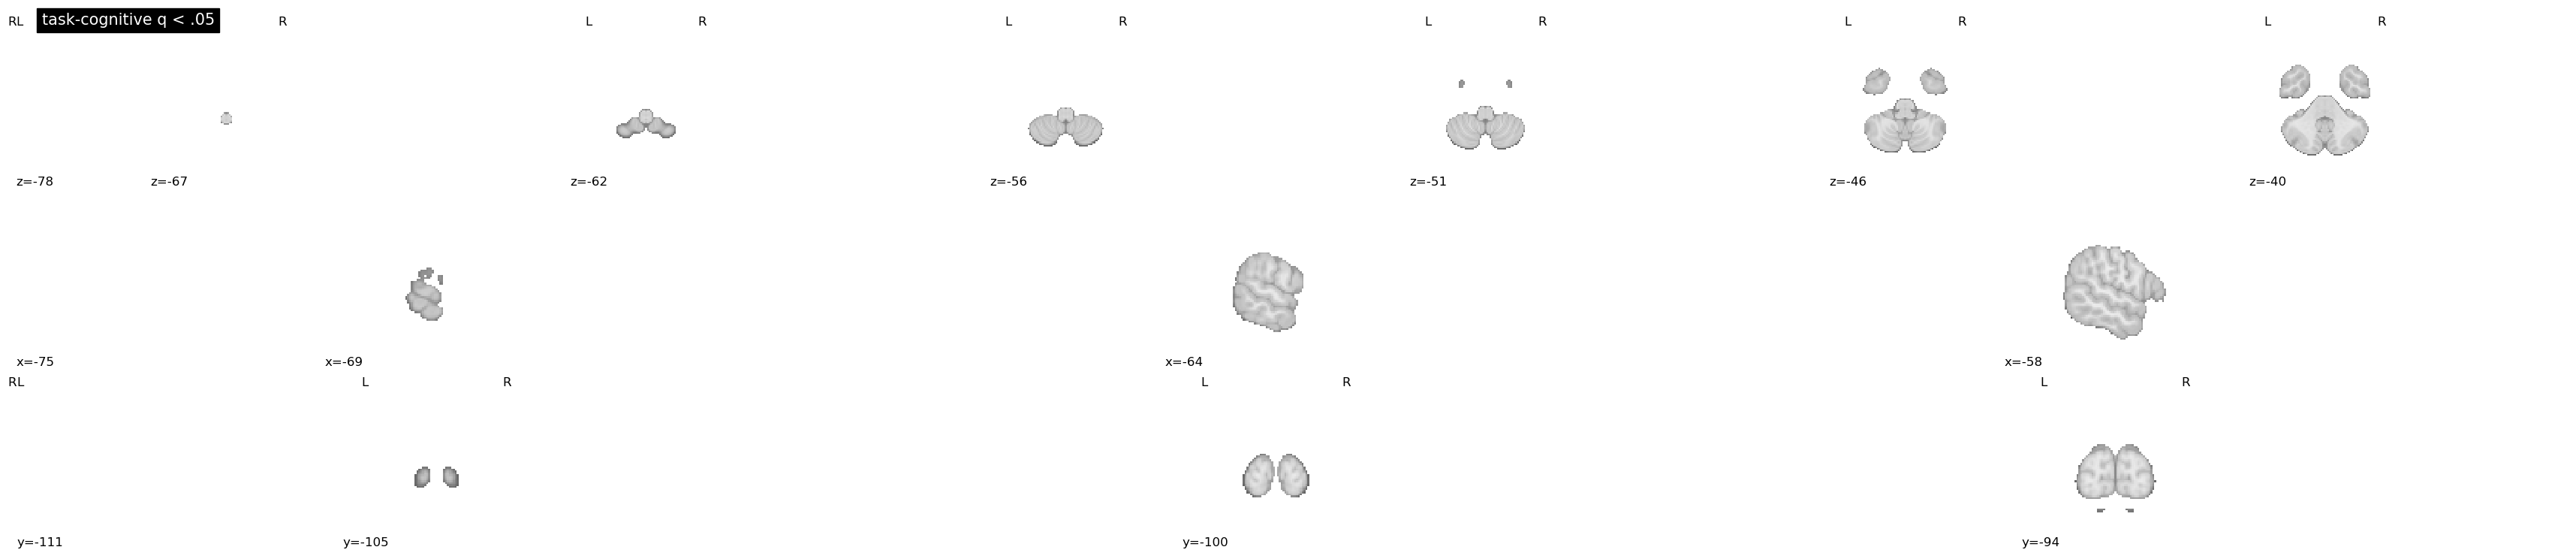

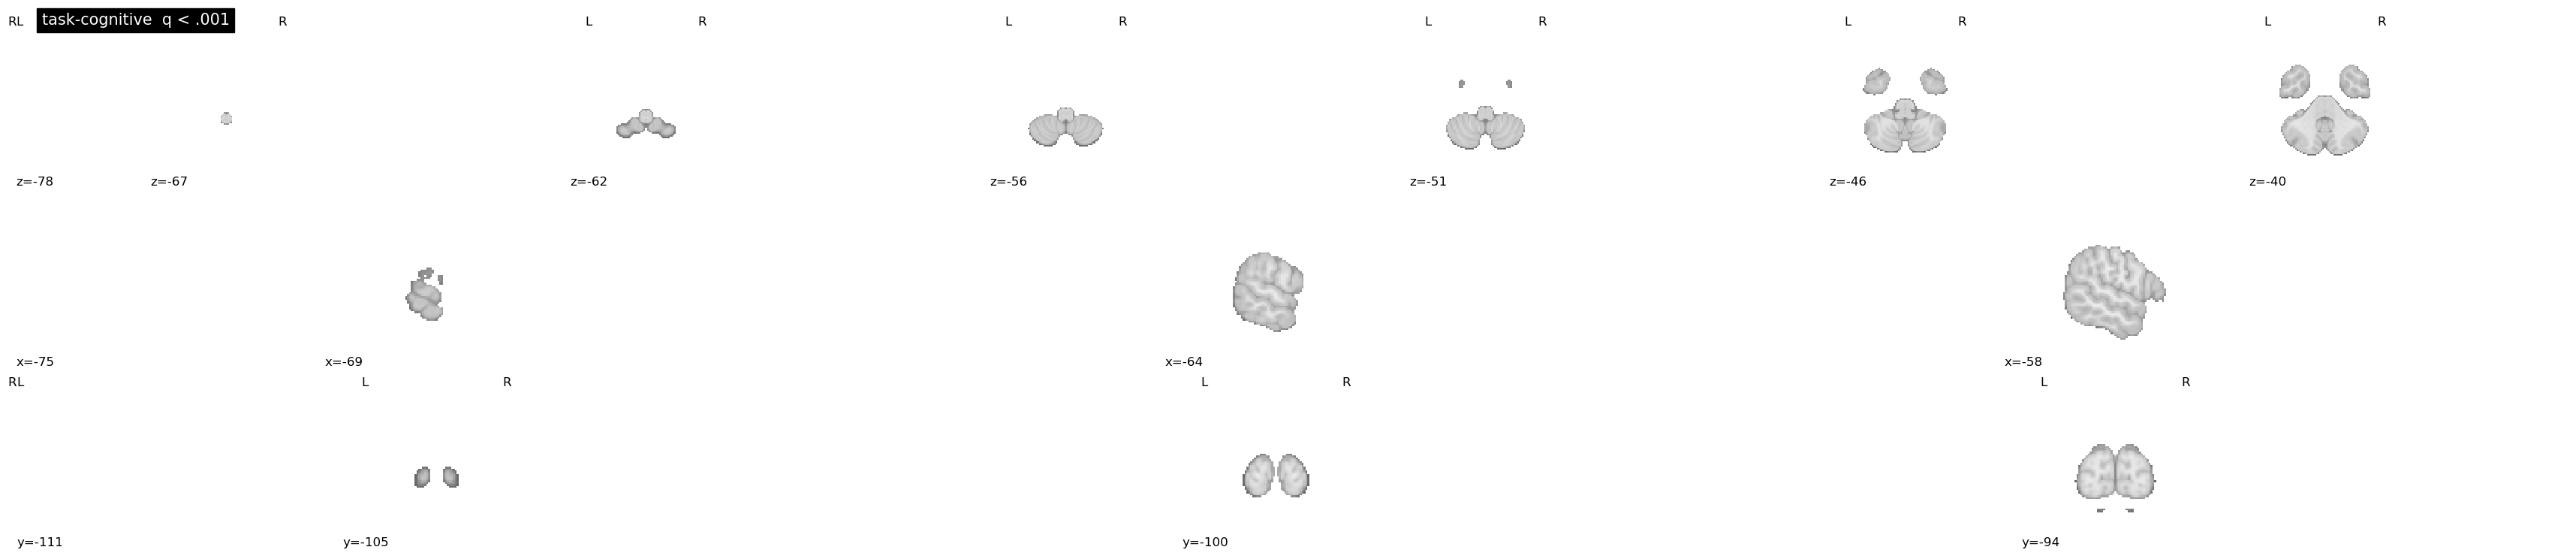

In [53]:
main_dir = '/Volumes/spacetop_projects_cue/'
task = 'cognitive'
fmri_event = 'stimulus'
beh_regressor = 'PE'
nii_flist = glob.glob(join(main_dir, 'analysis', 'fmri', 'nilearn', 'covariate', beh_regressor, task, f"sub-*_task-{task}_corr_x-{fmri_event}_y-{beh_regressor}.nii.gz" ))

remove_sub = [1]
nii_filtered_flist = [file_path for file_path in nii_flist if not any(str(num) in file_path for num in remove_sub)]

# stack all files into a 4d nifti
concat_cog_nii = image.concat_imgs(sorted(nii_filtered_flist))
fmri_masked_cog = nifti_masker.fit_transform(concat_cog_nii)

tvalues, pvalues = scipy.stats.ttest_1samp(fmri_masked_cog, popmean=0,axis=0, alternative='two-sided', nan_policy = 'propagate')
reject, qvalues, _, _ = multitest.multipletests(pvalues, method='fdr_bh')
tanhcorr_t = np.tanh(np.nanmean(fmri_masked_cog, axis = 0))
                     
# map 1
cog_con_t = nifti_masker.inverse_transform(tanhcorr_t)

# map 1-1
result_unc001 = np.zeros(fmri_masked_cog.shape[1])
result_unc001[pvalues < .001] = tanhcorr_t[pvalues < .001] #tvalues[qvalues < .05]
cog_corr_unc001 = nifti_masker.inverse_transform(result_unc001)

# map 2
result_mapp = np.zeros(fmri_masked_cog.shape[1])
result_mapp[qvalues < .05] = tanhcorr_t[qvalues < .05] #tvalues[qvalues < .05]
cog_corr_q05 = nifti_masker.inverse_transform(result_mapp)

# map 3
result_map_001p = np.zeros(fmri_masked_cog.shape[1])
result_map_001p[qvalues < .001] = tanhcorr_t[qvalues < .001] #tvalues[qvalues < .001]
cog_corr_q001 = nifti_masker.inverse_transform(result_map_001p)

plotting.plot_stat_map(cog_con_t,  display_mode = 'mosaic', title = f'task-{task} correlation', cut_coords = 8)
plotting.plot_stat_map(cog_corr_unc001,  display_mode = 'mosaic', title = f'task-{task} p < .001', cut_coords = 8)
plotting.plot_stat_map(cog_corr_q05,  display_mode = 'mosaic', title = f'task-{task} q < .05', cut_coords = 8)
plotting.plot_stat_map(cog_corr_q001,  display_mode = 'mosaic', title = f'task-{task}  q < .001', cut_coords = 8)